# Tensorflow Implementation of Gaussian VAE

In this notebook, we implemented a VAE where both the encoder and decoder model gaussian distributions. The model is trained on CelebA 64x64.

This implementation is in Tensorflow and supports multi-GPU.

For Pytorch and JAX implementations, check the other notebooks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
from tensorflow.keras.utils import array_to_img 
from tensorflow.keras.utils import load_img
from tensorflow.image import ResizeMethod
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.activations import exponential
from tensorflow_probability import distributions as tfd
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2024-03-03 19:21:15.302674: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 19:21:15.338872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 19:21:15.338913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 19:21:15.339623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 19:21:15.344490: I tensorflow/core/platform/cpu_feature_guar

## Distributed training 
Checking what devices we have avaliable (multiple gpus or single gpu/cpu) and picking strategy accordingly

In [2]:
if tf.config.list_logical_devices('GPU') != []:
    devices = tf.config.list_logical_devices('GPU')
else:
    devices = tf.config.list_logical_devices('CPU')
print(devices)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-03-03 19:21:17.266838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 19:21:17.297286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 19:21:17.297478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
if len(devices)>1:
    strategy = tf.distribute.MirroredStrategy(devices)
else:
    strategy = tf.distribute.OneDeviceStrategy(devices[0])

## Run Hyperparams

Define the training params.

`WARMUP_STEPS` defines the number of training updates over which we do a linear learning rate warmup. We found that such a learning rate warmup is very useful for model stability in the early stages of training.

`ENCODER_CONV_UNITS` and `DECODER_CONV_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[channels, kernel_size, stride, activation, name]`.

`ENCODER_DENSE_UNITS` and `DECODER_DENSE_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[channels, activation, name]`.

In [4]:
# Data params
INPUT_SHAPE = (64,64,3)

# Training params
BATCH_SIZE = 32
TOTAL_TRAINING_STEPS = 200000
EVAL_EVERY_N_STEPS = 2000
VALIDATION_STEPS = 50

# Optimizer params
INITIAL_LEARNING_RATE = 1e-3
DECAY_STEPS = 50000
DECAY_RATE = 0.5
WARMUP_STEPS = 1000

# Model params
ENCODER_CONV_UNITS = [[128,(4,4),(1,1), 'relu','enc_conv_one'],   
                      [128,(4,4),(2,2), 'relu','enc_conv_two'],   
                      [256,(4,4),(2,2), 'relu','enc_conv_three'], 
                      [256,(4,4),(2,2), 'relu','enc_conv_four'], 
                      [256,(4,4),(1,1), 'relu', 'enc_conv_five']]  

ENCODER_DENSE_UNITS = [[256, 'relu', 'enc_dense_one'], 
                       [256 * 2, None, 'enc_dense_two']]

DECODER_DENSE_UNITS = [[256, 'relu', 'dec_dense_one'], 
                       [256 * 8 * 8, 'relu', 'dec_dense_two']]

DECODER_CONV_UNITS = [[256,(4,4),(1,1), 'relu','dec_conv_one'],
                      [256,(4,4),(2,2), 'relu','dec_conv_two'],
                      [256,(4,4),(2,2), 'relu','dec_conv_three'],
                      [128,(4,4),(2,2), 'relu','dec_conv_four'],
                      [3*2,(4,4),(1,1), None, 'dec_conv_five']]

## Data processing

In [5]:
def create_filepaths():
    filenames = pd.read_csv('celeba-dataset/list_eval_partition.csv')

    train_filenames = filenames[filenames['partition'] == 0]['image_id'].values
    val_filenames = filenames[filenames['partition'] == 1]['image_id'].values

    path_to_files = 'celeba-dataset/img_align_celeba/img_align_celeba/'
    train_filepaths = path_to_files + train_filenames
    val_filepaths = path_to_files+val_filenames
    
    return train_filepaths, val_filepaths

def load_img(path):
    img = tf.keras.utils.load_img(path)
    return img

def map_fn(path, img2):
    img = tf.numpy_function(load_img, inp=[path], Tout=tf.uint8)

    # Crop the CelebA images to be centered on the face.
    img = tf.image.crop_to_bounding_box(img, 40, 15, 148, 148)
    # Resize and Normalize
    img = tf.image.resize(img, INPUT_SHAPE[:2], ResizeMethod.BILINEAR) / 255
    img2=img
    return img, img2

def create_dataset(path):
    dataset = tf.data.Dataset.from_tensor_slices(path)
    dataset = tf.data.Dataset.zip(dataset, dataset)
    dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=2409,reshuffle_each_iteration=True)
    dataset = dataset.map(map_fn, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size = BATCH_SIZE, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_filepaths, val_filepaths = create_filepaths()
train_dataset = create_dataset(train_filepaths)
val_dataset = create_dataset(val_filepaths)

# Distribute the dataset across GPUs
dist_train = strategy.experimental_distribute_dataset(train_dataset)
dist_val =strategy.experimental_distribute_dataset(val_dataset)

2024-03-03 19:21:17.702459: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


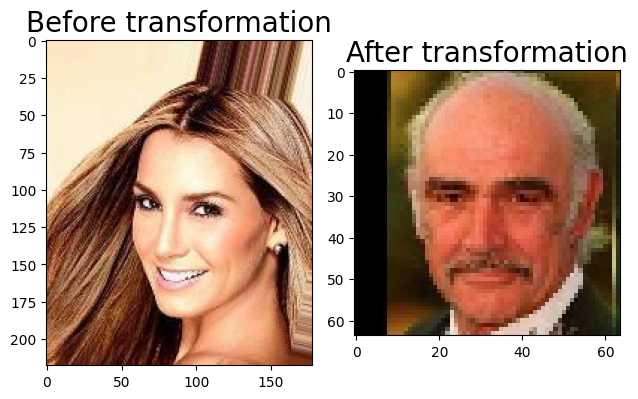

In [6]:
_, axes = plt.subplots(1, 2)
 
for i,_ in train_dataset:
    axes[0].imshow(load_img(train_filepaths[0]))
    axes[0].set_title('Before transformation',fontsize=20)
    axes[1].imshow(i[0])
    axes[1].set_title('After transformation',fontsize=20)
    plt.tight_layout()
    plt.show()
    break

## Definining loss

For the Loss, we use the `Negative ELBO = -likelihood + KL_div`.

- `likelihood = decoder_dist.log_pdf(targets)`
- `KL_div = KL(posterior_dist || prior_dist)`
- The `posterior_dist` is the encoder distribution.
- For simplicity, we set the prior distribution to be a simple standard Gaussian `N(0, 1)`.

To help the model avoid a posterior collapse, we warmup the `KL_div` by linearly scaling it up over 10000 steps.

In [7]:
# Define the shape of z based on hparams
def z_shape():
    return [BATCH_SIZE//len(devices), ENCODER_DENSE_UNITS[-1][0] // 2]

print(z_shape())

class NelboLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.prior = tfd.Normal(tf.zeros(z_shape()),tf.ones(z_shape()))    # (B, 1, 1, z_C)
        
    def __call__(self, dec_mean, dec_logstd,enc_mean,enc_logstd, targets,step):
        likelihood = tfd.Normal(dec_mean, tf.math.exp(tf.maximum(dec_logstd, -10.))).log_prob(targets)     # (B, H, W, 3)
        kl = tfd.kl_divergence(tfd.Normal(enc_mean,tf.math.exp(tf.maximum(enc_logstd,-10.))),self.prior)   # (B, 1, 1, 3)
        denominator = tf.cast(tf.reduce_prod(likelihood.shape),dtype=tf.float32)*len(devices)
        reconstuction_loss =-tf.reduce_sum(likelihood)/denominator
        kl_loss = (tf.reduce_sum(kl)/denominator)*tf.minimum(tf.cast(step, dtype=tf.float32)*1e-4,1.)
        neg_elbo = reconstuction_loss+kl_loss    # ()
        return neg_elbo, reconstuction_loss, kl_loss


[32, 256]


## Defining model

In [8]:
# Define the unflatten shape used in the decoder based on hparams
def unflatten_shape():
    h,w = INPUT_SHAPE[:2]
    for stride in ENCODER_CONV_UNITS:
        h = h//stride[2][0]
        w = w//stride[2][1]   
    
    assert DECODER_DENSE_UNITS[-1][0] % (h*w) == 0
    unflatten_C = DECODER_DENSE_UNITS[-1][0] // (h*w)
    x=[BATCH_SIZE//len(devices), h, w, unflatten_C]
    return x

print(unflatten_shape())

[32, 8, 8, 256]


In [9]:
class EncoderConvs(tf.keras.layers.Layer):
    """
    Encoder Block.

    The Block is made of convolutions that downsample the image
    resolution until a certain point, after which we flatten the image
    and use a stack of Dense layers to get the posterior distribution q(z|x).
    """
    def __init__(self, name='encoder_convs'):
        super(EncoderConvs, self).__init__(name=name)
        self.convs_list=[]        
        for ch,k,st, act, name in ENCODER_CONV_UNITS:            
            self.convs_list.append(Conv2D(ch, k, st,'same', activation=act, name=name))
            
        self.dense_list = []
        for ch, act, name in ENCODER_DENSE_UNITS:
            self.dense_list.append(Dense(ch, activation=act, name=name))
            
        self.flatten_op = Flatten()
                
    def call(self, x):
        for conv in self.convs_list:
            x = conv(x)
            
        x = self.flatten_op(x)
        
        for dense in self.dense_list:
            x = dense(x)
        return x  

class ResizeAndConv(tf.keras.layers.Layer):
    """
    Resize-Conv Block.

    A simple Nearest-Neighbord upsampling + Conv block, used to upsample images instead of Deconv layers.
    This block is useful to avoid checkerboard artifacts: https://distill.pub/2016/deconv-checkerboard/
    """
    def __init__(self, filters, kernel_size, stride, activation, name):
        super(ResizeAndConv,self).__init__()
        self.stride = stride
        self.conv = Conv2D(filters,kernel_size,(1,1),'same',activation=activation, name=name)
        
    def call(self,x):
        if self.stride != (1,1):
            x = tf.image.resize(x, [x.shape[1]*self.stride[0],x.shape[2]*self.stride[1]], method = 'nearest')
        x = self.conv(x)
        return x

class DecoderConvs(tf.keras.layers.Layer):
    """
    Decoder Block.

    The Decoder block starts off with Dense layers to process the sample z,
    followed by an unflatten (reshape) operation into an activation of shape (B, h, w, C).
    The activation is then upsampled back to the original image size using a stack
    of resize-conv blocks.
    """
    def __init__(self, name='decoder_convs'):
        super(DecoderConvs, self).__init__(name=name)
        self.convs_list=[]        
        for ch,k,st,act, name in DECODER_CONV_UNITS:            
            self.convs_list.append(ResizeAndConv(ch, k, st, activation=act, name=name))
            
        self.dense_list = []
        for ch, act, name in DECODER_DENSE_UNITS:
            self.dense_list.append(Dense(ch, activation=act, name=name))
                
    def call(self,x):
        for dense in self.dense_list:
            x = dense(x)
        
        x = tf.reshape(x, shape=unflatten_shape())
        
        for conv in self.convs_list:
            x = conv(x)
        return x   

    
class VAEModel(Model):
    """
    VAE model.

    A simple Encoder-Decoder architecture where both Encoder and Decoder model multivariate
    gaussian distributions.
    """
    def __init__(self, name='vae_model'):
        super(VAEModel, self).__init__(name=name)
        self.encoder_convs = EncoderConvs()
        self.decoder_convs = DecoderConvs()

           
    def call(self,inputs):
        enc_mean, enc_logstd = self.encode(inputs)           # (B, 1, 1, z_C)

        # Reparametrization Trick (allow backprop)
        epsilon = tf.random.normal(tf.shape(enc_mean))       # (B, 1, 1, z_C)
        z = epsilon*tf.math.exp(enc_logstd)+enc_mean         # (B, 1, 1, z_C)
        
        dec_mean, dec_logstd = self.decode(z)                # (B, H, W, 3)  
        return enc_mean, enc_logstd, dec_mean, dec_logstd
    
    def encode(self,inputs):
        x = self.encoder_convs(inputs)                # (B, 1, 1, z_C * 2)
        enc_mean, enc_logstd = tf.split(x,2,-1,2)     # (B, 1, 1, z_C)
        return enc_mean, enc_logstd
    
    def decode(self,z):
        x = self.decoder_convs(z)                     # (B, H, W, 3 * 2)
        dec_mean, dec_logstd = tf.split(x,2,-1,2)     # (B, H, W, 3)
        return dec_mean, dec_logstd
    
    def generate(self, z_temp=1., x_temp=1.):
        """
        Randomly sample z from the prior distribution N(0, 1) and generate the image x from z.

        z_temp: float, defines the temperature multiplier of the encoder stddev. 
            Smaller z_temp makes the generated samples less diverse and more generic
        x_temp: float, defines the temperature multiplier of the decoder stddev.
            Smaller x_temp makes the generated samples smoother, and loses small degree of information.
        """
        # Generate random samples from the prior distribution N(0, 1)
        z = tf.random.normal(z_shape(), mean=0., stddev=1. * z_temp)
        dec_mean, dec_logstd = self.decode(z)
        return tfd.Normal(dec_mean,tf.math.exp(dec_logstd) * x_temp).sample()

    def model(self):
        x = Input((64,64,3),name='input_layer')
        return Model(inputs=x, outputs=self.call(x), name='vae_model')

In [10]:
# distribute the model
with strategy.scope():
    model = VAEModel()
    model.model().summary()

Model: "vae_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder_convs (EncoderConv  (None, 512)                  7216896   ['input_layer[0][0]']         
 s)                                                                                               
                                                                                                  
 tf.split (TFOpLambda)       [(None, 256),                0         ['encoder_convs[0][0]']       
                              (None, 256)]                                                        
                                                                                          

## utility functions for training

Saving and Loading checkpoints

In [11]:
def create_checkpoint_manager(checkpoint_path, model, optimizer, max_allowed_checkpoints=2):
    checkpoint_starter = tf.Variable(0, trainable=False, dtype=tf.int32)
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model, checkpoint_starter=checkpoint_starter)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_path, max_to_keep=max_allowed_checkpoints)    
    return manager

def save_checkpoint(step, checkpoint_manager):
    checkpoint_manager.checkpoint.checkpoint_starter.assign(step)
    checkpoint_manager.save(step)
    
def load_checkpoint_if_exists(manager):
    checkpoint_path = manager.directory
    checkpoint = manager.checkpoint
    try:
        checkpoint_state = tf.train.get_checkpoint_state(checkpoint_path)
        if checkpoint_state and checkpoint_state.model_checkpoint_path:
            print('Loading checkpoint from: {}'.format(checkpoint_state.model_checkpoint_path))
            checkpoint.restore(checkpoint_state.model_checkpoint_path)
        
        else:
            print('No model to load at {}'.format(checkpoint_path))
    
    except tf.errors.OutOfRangeError as e:
        raise tf.errors.OutOfRangeError('Cannot restore checkpoint: {}'.format(e))

Metrics book keeping and plotting utilities

In [12]:
def plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets):
    _, axes = plt.subplots(1,8,figsize=(8,4))
    axes[0].imshow(ttargets[0])
    axes[1].imshow(tfd.Normal(tdec_mean[0],tf.math.exp(tdec_logstd[0])).sample())
    axes[2].imshow(ttargets[1])
    axes[3].imshow(tfd.Normal(tdec_mean[1],tf.math.exp(tdec_logstd[1])).sample())
    axes[4].imshow(vtargets[0])
    axes[5].imshow(tfd.Normal(vdec_mean[0],tf.math.exp(vdec_logstd[0])).sample())
    axes[6].imshow(vtargets[1])
    axes[7].imshow(tfd.Normal(vdec_mean[1],tf.math.exp(vdec_logstd[1])).sample())
    plt.tight_layout(pad=-2.)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 

# Updates dictionary that stores changes in loss values
def get_results(results, losses):
    for i,key in enumerate(results.keys()):
        results[key].append(losses[i].numpy())

Learning rate schedule utility

In [13]:
class WarmupExponentialDecay(tf.keras.optimizers.schedules.ExponentialDecay):
    """
    Exponential Decay Learning rate schedule with warmup phase
    """
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, warmup_steps=500, 
                 staircase=False, name=None):
        super(WarmupExponentialDecay, self).__init__(initial_learning_rate,decay_steps,decay_rate,
                                                     staircase,name)
        self.warmup_steps = warmup_steps
        self.initial_learning_rate = initial_learning_rate

    @tf.function
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        if step <= self.warmup_steps:
            lr = self.initial_learning_rate * tf.minimum(1., step / self.warmup_steps)  # Linear warmup
            
        else:
            lr = super(WarmupExponentialDecay, self).__call__(step - self.warmup_steps)
        
        return lr

lr_schedule = WarmupExponentialDecay(initial_learning_rate=INITIAL_LEARNING_RATE,
                               decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, warmup_steps=WARMUP_STEPS, 
                                     staircase=False, name=None)

Training loop utilities

In [14]:
def trainval_step(inputs, targets, step, training=True):
    """
    Train/Val step based on the training argument.
    """
    if training:
        with tf.GradientTape() as tape:
            enc_mean, enc_logstd, dec_mean, dec_logstd = model(inputs, training=True)
            loss_value,reconstuction_loss,kl_loss = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets,step)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss_value,reconstuction_loss, kl_loss

    else:
        enc_mean, enc_logstd, dec_mean, dec_logstd = model(inputs, training=False)
        loss_value,reconstuction_loss,kl_loss = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets,step)
        return loss_value, reconstuction_loss, kl_loss, dec_mean, dec_logstd
    
@tf.function
def distributed_trainval_step(inputs, targets, step, training=True):
    """
    Distributed (across GPUs) wrapper of train_val_step

    This function is also decorated with tf.function to be converted into a graph and XLA compiled.
    """
    if training:
        loss_value,reconstuction_loss, kl_loss = strategy.run(trainval_step, args=(inputs, targets, step, training))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, loss_value,axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, reconstuction_loss,axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, kl_loss,axis=None)
    else:
        loss_value,reconstuction_loss, kl_loss, dec_mean, dec_logstd = strategy.run(trainval_step, args=(inputs, targets, step, training))
        return (strategy.reduce(tf.distribute.ReduceOp.SUM, loss_value,axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, reconstuction_loss,axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, kl_loss,axis=None),
                strategy.gather(dec_mean, axis=0),strategy.gather(dec_logstd, axis=0),
               strategy.gather(targets, axis=0))
   
    
def validate(dataset, step):
    """
    Validation loop. 
    """
    avarage_loss = 0.
    avarage_rec_loss = 0.
    avarage_kl_loss = 0.
   
    for val_step,(inputs, targets) in zip(range(VALIDATION_STEPS), dataset):
        loss_value,reconstuction_loss, kl_loss,dec_mean, dec_logstd, targets = distributed_trainval_step(inputs, targets,tf.convert_to_tensor(step), training=False) 
        avarage_loss += loss_value
        avarage_rec_loss += reconstuction_loss
        avarage_kl_loss += kl_loss
           
    avarage_loss /= (val_step + 1)
    avarage_rec_loss /= (val_step + 1)
    avarage_kl_loss /= (val_step + 1)  
    return avarage_loss,avarage_rec_loss,avarage_kl_loss, dec_mean[:2], dec_logstd[:2], targets[:2]

def validate_and_plot(train_dataset,val_dataset,step):
    """
    Validation function for both train and val data + metrics and artifacts logging.
    """
    avarage_train_loss,avarage_train_rec_loss,avarage_train_kl_loss,tdec_mean, tdec_logstd,ttargets= validate(train_dataset, step)    
    avarage_val_loss,avarage_val_rec_loss,avarage_val_kl_loss,vdec_mean, vdec_logstd, vtargets = validate(val_dataset, step)
    tf.print(f"\nstep {step}/{TOTAL_TRAINING_STEPS}  train_loss:  nelbo:{avarage_train_loss:.4f}  rec:{avarage_train_rec_loss:.4f}  kl:{avarage_train_kl_loss:.4f}      val_loss:  nelbo:{avarage_val_loss:.4f}  rec:{avarage_val_rec_loss:.4f}  kl:{avarage_val_kl_loss:.4f}")
    plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets)  
    print('')
    return avarage_train_loss,avarage_train_rec_loss,avarage_train_kl_loss,avarage_val_loss,avarage_val_rec_loss,avarage_val_kl_loss

def train(train_dataset, val_dataset, results):
    """
    Training loop
    """
    # Restore model if resuming training
    load_checkpoint_if_exists(manager)
    
    initial_step = manager.checkpoint.checkpoint_starter.read_value().numpy()
    pbar = tf.keras.utils.Progbar(EVAL_EVERY_N_STEPS, stateful_metrics=['nelbo','rec','kl'])

    for step, (train_inputs, train_targets) in zip(range(initial_step, TOTAL_TRAINING_STEPS+1),train_dataset):
        loss_value, reconstuction_loss, kl_loss = distributed_trainval_step(train_inputs, train_targets, tf.convert_to_tensor(step), training=True) 
        pbar.update(step % EVAL_EVERY_N_STEPS, [('nelbo', loss_value),('rec', reconstuction_loss),('kl', kl_loss)])
                    
        if (step % EVAL_EVERY_N_STEPS == 0):
            losses = validate_and_plot(train_dataset, val_dataset,step)
            # update the results dict with latest metrics
            get_results(results, losses)

            # Save new model checkpoint
            save_checkpoint(step, manager)
            print(f'SAVED CHECKPOINT FOR STEP {step}..')

## Model training

In [15]:
# Define this run's model name
MODEL_NAME = 'vae_celeba64_dense256'
loss = NelboLoss()

with strategy.scope():
    optimizer = Adamax(lr_schedule)
    
manager = create_checkpoint_manager(f'tensorflow_checkpoints/{MODEL_NAME}', model, optimizer)

No model to load at tensorflow_checkpoints/debug


2024-03-03 19:21:21.901045: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-03 19:21:21.965202: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 19:21:24.450835: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2795b8ff60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 19:21:24.450859: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-03-03 19:21:24.453549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709511684.513243  599719 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   0/2000 [..............................] - ETA: 0s - nelbo: 1.0612 - rec: 1.0612 - kl: 0.0000e+00
step 0/200000  train_loss:  nelbo:1.0656  rec:1.0656  kl:0.0000      val_loss:  nelbo:1.0679  rec:1.0679  kl:0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


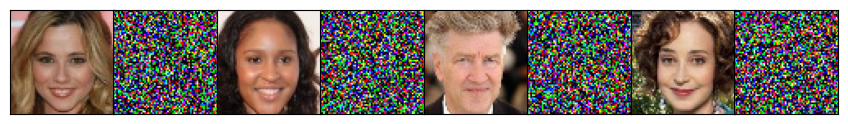


SAVED CHECKPOINT FOR STEP 0..
   0/2000 [..............................] - ETA: 0s - nelbo: -0.7773 - rec: -0.7908 - kl: 0.0136
step 2000/200000  train_loss:  nelbo:-0.8446  rec:-0.8572  kl:0.0126      val_loss:  nelbo:-0.8323  rec:-0.8448  kl:0.0125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


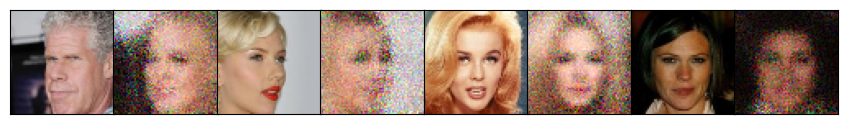


SAVED CHECKPOINT FOR STEP 2000..
  67/2000 [>.............................] - ETA: 2:34 - nelbo: -0.5659 - rec: -0.5747 - kl: 0.0088

KeyboardInterrupt: 

In [16]:
results = {'nelbo':[],'rec':[],'kl':[],'val_nelbo':[],'val_rec':[],'val_kl':[]}
start_time=time()
train(dist_train,dist_val, results)
end_time=time()
print(f'Total time for {TOTAL_TRAINING_STEPS} is {end_time-start_time:.2f}s')

Plot the loss curves

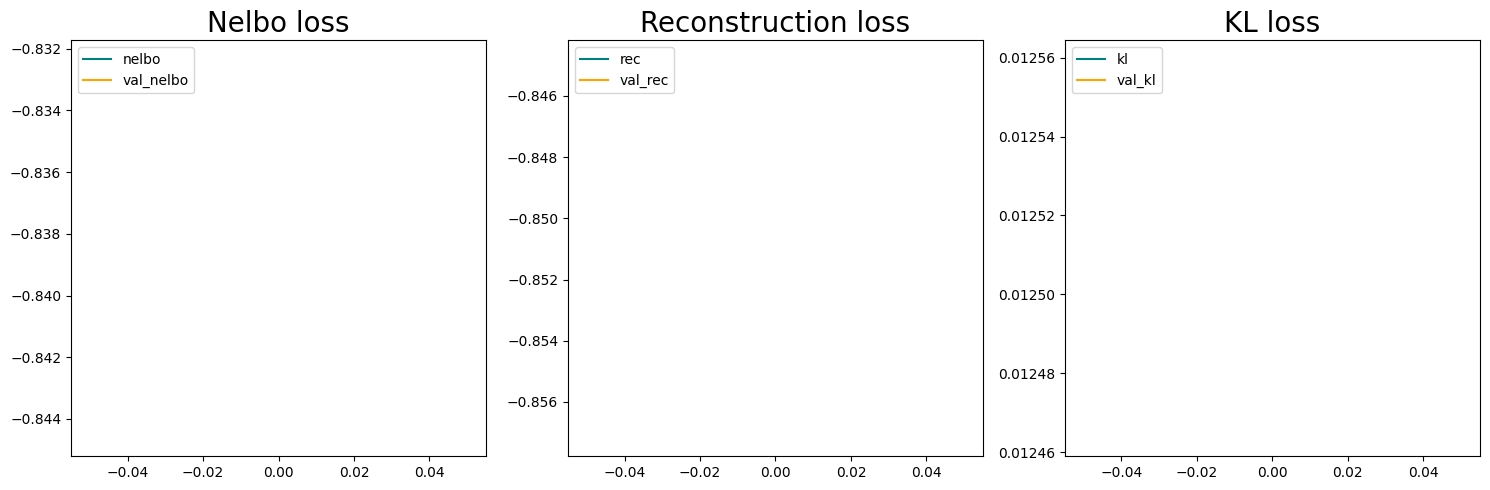

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(results['nelbo'][1:], color='teal', label='nelbo')
axes[0].plot(results['val_nelbo'][1:], color='orange', label='val_nelbo')
axes[0].set_title('Nelbo loss', fontsize=20)
axes[0].legend(loc="upper left")

axes[1].plot(results['rec'][1:], color='teal', label='rec')
axes[1].plot(results['val_rec'][1:], color='orange', label='val_rec')
axes[1].set_title('Reconstruction loss', fontsize=20)
axes[1].legend(loc="upper left")

axes[2].plot(results['kl'][1:], color='teal', label='kl')
axes[2].plot(results['val_kl'][1:], color='orange', label='val_kl')
axes[2].set_title('KL loss', fontsize=20)
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

## Model Generation

In this section, we generate new images from the prior distribution

In [18]:
# choose the model to generate from
MODEL_NAME = 'vae_celeba64_dense256'

with strategy.scope():
    model = VAEModel()
    optimizer = Adamax(lr_schedule)
    
manager = create_checkpoint_manager(f'tensorflow_checkpoints/{MODEL_NAME}', model, optimizer)
load_checkpoint_if_exists(manager)

Loading checkpoint from: tensorflow_checkpoints/vae_celeba64_dense256/ckpt-200000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


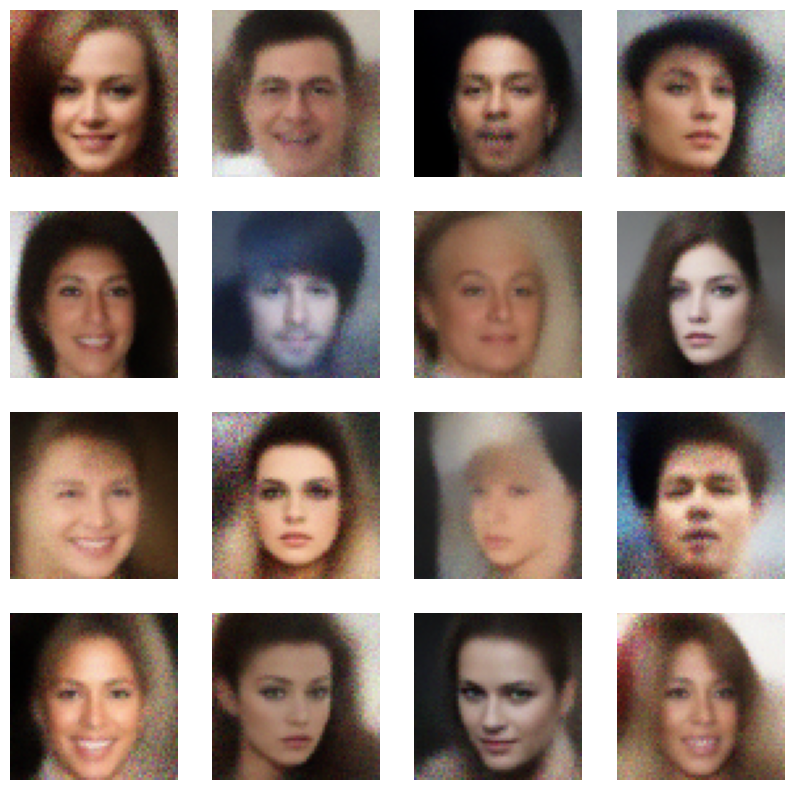

In [19]:
# Pick encoder distribution temperature (z_temp) and decoder distribution temperature (x_temp)
# Generate from the prior
pictures = model.generate(z_temp=1., x_temp=0.3)

# Plot grid of generated pictures
fig, axes32 = plt.subplots(4,4, figsize=(10,10))
for i, axes8 in enumerate(axes32):
    for j, ax in enumerate(axes8):
        index = i * axes32.shape[1] + j
        ax.imshow(pictures[index])
        ax.axis('off')
plt.show()